# Prediction of teams that will reach the Playoffs

## Data Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
! pip install tabulate
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder

players = pd.read_csv('basketballPlayoffs/players.csv', delimiter=",")
coaches = pd.read_csv('basketballPlayoffs/coaches.csv', delimiter=",")
teams = pd.read_csv('basketballPlayoffs/teams.csv', delimiter=",")
players_teams = pd.read_csv('basketballPlayoffs/players_teams.csv', delimiter=",")
teams_post = pd.read_csv('basketballPlayoffs/teams_post.csv', delimiter=",")
series_post = pd.read_csv('basketballPlayoffs/series_post.csv', delimiter=",")
awards_players = pd.read_csv('basketballPlayoffs/awards_players.csv', delimiter=",")
awards_coaches = pd.read_csv('basketballPlayoffs/awards_coaches.csv', delimiter=",")

print(players.head())
print(coaches)
print(teams)
print(players_teams)
print(teams_post)
print(series_post)
print(awards_players)
print(awards_coaches)

c:\Users\anete\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


     playerID  pos  firstseason  lastseason  height  weight  \
0  abrahta01w    C            0           0    74.0     190   
1  abrossv01w    F            0           0    74.0     169   
2  adairje01w    C            0           0    76.0     197   
3  adamsda01w  F-C            0           0    73.0     239   
4  adamsjo01w    C            0           0    75.0     180   

             college            collegeOther   birthDate   deathDate  
0  George Washington                     NaN  1975-09-27  0000-00-00  
1        Connecticut                     NaN  1980-07-09  0000-00-00  
2  George Washington                     NaN  1986-12-19  0000-00-00  
3          Texas A&M  Jefferson College (JC)  1989-02-19  0000-00-00  
4         New Mexico                     NaN  1981-05-24  0000-00-00  
        coachID  year tmID  lgID  stint  won  lost  post_wins  post_losses
0    adamsmi01w     5  WAS  WNBA      0   17    17          1            2
1    adubari99w     1  NYL  WNBA      0   20 

## Data cleaning

Check for missing values, outliers, and inconsistencies in the data. Clean and preprocess the data to ensure it's ready for analysis.

### Teams dataset

In [2]:
print(teams.isna().sum())
print(teams.head())

year        0
lgID        0
tmID        0
franchID    0
confID      0
           ..
confW       0
confL       0
min         0
attend      0
arena       0
Length: 61, dtype: int64
   year  lgID tmID franchID confID  divID  rank playoff  seeded firstRound  \
0     9  WNBA  ATL      ATL     EA    NaN     7       N       0        NaN   
1    10  WNBA  ATL      ATL     EA    NaN     2       Y       0          L   
2     1  WNBA  CHA      CHA     EA    NaN     8       N       0        NaN   
3     2  WNBA  CHA      CHA     EA    NaN     4       Y       0          W   
4     3  WNBA  CHA      CHA     EA    NaN     2       Y       0          L   

   ...  GP homeW homeL  awayW  awayL  confW  confL   min  attend  \
0  ...  34     1    16      3     14      2     18  6825  141379   
1  ...  34    12     5      6     11     10     12  6950  120737   
2  ...  32     5    11      3     13      5     16  6475   90963   
3  ...  32    11     5      7      9     15      6  6500  105525   
4  ...  32  

### Players Teams dataset

In [3]:
print(players_teams.isna().sum())
print(players_teams.head())

playerID              0
year                  0
stint                 0
tmID                  0
lgID                  0
GP                    0
GS                    0
minutes               0
points                0
oRebounds             0
dRebounds             0
rebounds              0
assists               0
steals                0
blocks                0
turnovers             0
PF                    0
fgAttempted           0
fgMade                0
ftAttempted           0
ftMade                0
threeAttempted        0
threeMade             0
dq                    0
PostGP                0
PostGS                0
PostMinutes           0
PostPoints            0
PostoRebounds         0
PostdRebounds         0
PostRebounds          0
PostAssists           0
PostSteals            0
PostBlocks            0
PostTurnovers         0
PostPF                0
PostfgAttempted       0
PostfgMade            0
PostftAttempted       0
PostftMade            0
PostthreeAttempted    0
PostthreeMade   

### Players dataset

In [4]:
print(players.isna().sum())
print(players.head())

playerID          0
pos              78
firstseason       0
lastseason        0
height            0
weight            0
college         167
collegeOther    882
birthDate         0
deathDate         0
dtype: int64
     playerID  pos  firstseason  lastseason  height  weight  \
0  abrahta01w    C            0           0    74.0     190   
1  abrossv01w    F            0           0    74.0     169   
2  adairje01w    C            0           0    76.0     197   
3  adamsda01w  F-C            0           0    73.0     239   
4  adamsjo01w    C            0           0    75.0     180   

             college            collegeOther   birthDate   deathDate  
0  George Washington                     NaN  1975-09-27  0000-00-00  
1        Connecticut                     NaN  1980-07-09  0000-00-00  
2  George Washington                     NaN  1986-12-19  0000-00-00  
3          Texas A&M  Jefferson College (JC)  1989-02-19  0000-00-00  
4         New Mexico                     NaN  1981-05

### Coaches dataset

In [5]:
print(coaches.isna().sum())
print(coaches.head())

coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64
      coachID  year tmID  lgID  stint  won  lost  post_wins  post_losses
0  adamsmi01w     5  WAS  WNBA      0   17    17          1            2
1  adubari99w     1  NYL  WNBA      0   20    12          4            3
2  adubari99w     2  NYL  WNBA      0   21    11          3            3
3  adubari99w     3  NYL  WNBA      0   18    14          4            4
4  adubari99w     4  NYL  WNBA      0   16    18          0            0


### Awards Players dataset

In [6]:
print(awards_players.isna().sum())
print(awards_players.head())

playerID    0
award       0
year        0
lgID        0
dtype: int64
     playerID                               award  year  lgID
0  thompti01w  All-Star Game Most Valuable Player     1  WNBA
1  leslili01w  All-Star Game Most Valuable Player     2  WNBA
2  leslili01w  All-Star Game Most Valuable Player     3  WNBA
3  teaslni01w  All-Star Game Most Valuable Player     4  WNBA
4  swoopsh01w  All-Star Game Most Valuable Player     6  WNBA


### Awards Coaches dataset

In [7]:
print(awards_coaches.isna().sum())
print(awards_coaches.head())

coachID    0
award      0
year       0
lgID       0
dtype: int64
      coachID              award  year  lgID
0  coopemi01w  Coach of the Year     1  WNBA
1  hugheda99w  Coach of the Year     2  WNBA
2  stanlma99w  Coach of the Year     3  WNBA
3  laimbbi01w  Coach of the Year     4  WNBA
4  mcconsu01w  Coach of the Year     5  WNBA


## Exploratory Data Analysis (EDA)

Conduct EDA to gain insights into the data. Visualize distributions, correlations, and patterns. This step will help you understand the relationships between different features and the target variable.

### Teams metrics

In [8]:
teams.head()

teams.isnull().sum()

year        0
lgID        0
tmID        0
franchID    0
confID      0
           ..
confW       0
confL       0
min         0
attend      0
arena       0
Length: 61, dtype: int64

In [9]:
for column in teams.columns:
    unique_values = teams[column].unique()
    print(f"Number of different values in the {column} column are:", len(unique_values))
    print("------------")

Number of different values in the year column are: 10
------------
Number of different values in the lgID column are: 1
------------
Number of different values in the tmID column are: 20
------------
Number of different values in the franchID column are: 18
------------
Number of different values in the confID column are: 2
------------
Number of different values in the divID column are: 1
------------
Number of different values in the rank column are: 8
------------
Number of different values in the playoff column are: 2
------------
Number of different values in the seeded column are: 1
------------
Number of different values in the firstRound column are: 3
------------
Number of different values in the semis column are: 3
------------
Number of different values in the finals column are: 3
------------
Number of different values in the name column are: 20
------------
Number of different values in the o_fgm column are: 116
------------
Number of different values in the o_fga column a

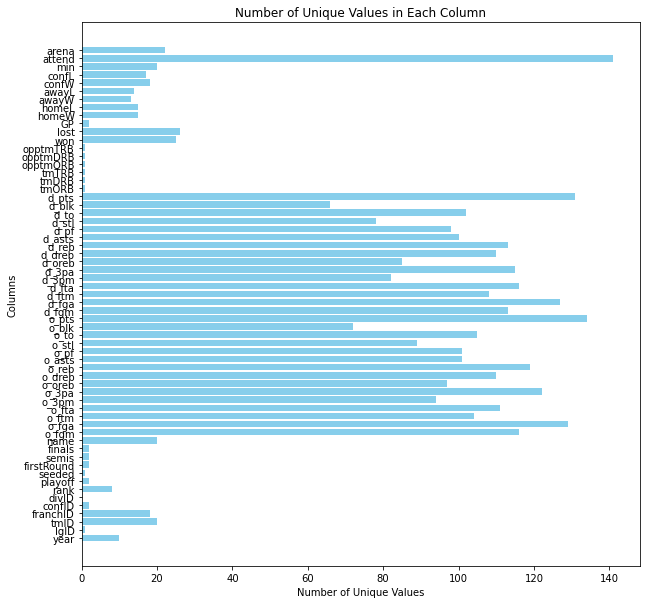

In [10]:
columns = []
value_counts = []

for column in teams.columns:
    unique_values = teams[column].nunique()
    columns.append(column)
    value_counts.append(unique_values)

plt.figure(figsize=(10, 10))
plt.barh(columns, value_counts, color='skyblue')
plt.xlabel('Number of Unique Values')
plt.ylabel('Columns')
plt.title('Number of Unique Values in Each Column')
plt.show()

In [11]:
print(teams.dtypes)

year         int64
lgID        object
tmID        object
franchID    object
confID      object
             ...  
confW        int64
confL        int64
min          int64
attend       int64
arena       object
Length: 61, dtype: object


In [12]:
teams_numeric = teams.copy()

for column in teams_numeric.columns:
    if teams_numeric[column].dtype == 'object':
        teams_numeric[column] = teams_numeric[column].astype('category').cat.codes

teams_numeric.describe()

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
count,142.000000,142.0,142.000000,142.000000,142.000000,0.0,142.000000,142.000000,142.0,142.00000,...,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,5.302817,0.0,10.070423,9.415493,0.507042,NaN,4.084507,0.563380,0.0,-0.15493,...,33.323944,10.169014,6.492958,6.492958,10.169014,10.563380,10.563380,6735.683099,141050.253521,10.838028
std,2.917274,0.0,5.426031,4.906564,0.501720,NaN,2.095226,0.497722,0.0,0.83620,...,0.949425,2.994017,2.967308,2.702104,2.731409,3.485461,3.485461,197.851093,34714.358519,6.565153
min,1.000000,0.0,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.0,-1.00000,...,32.000000,1.000000,0.000000,1.000000,3.000000,2.000000,2.000000,6400.000000,57635.000000,0.000000
25%,3.000000,0.0,6.000000,5.000000,0.000000,NaN,2.000000,0.000000,0.0,-1.00000,...,32.000000,8.000000,4.250000,5.000000,9.000000,8.000000,8.000000,6500.000000,120897.500000,6.000000
50%,5.000000,0.0,10.000000,10.000000,1.000000,NaN,4.000000,1.000000,0.0,0.00000,...,34.000000,11.000000,6.000000,6.000000,10.000000,11.000000,10.000000,6825.000000,135895.500000,10.000000
75%,8.000000,0.0,15.000000,14.000000,1.000000,NaN,6.000000,1.000000,0.0,1.00000,...,34.000000,12.000000,8.000000,8.000000,12.000000,13.000000,13.000000,6875.000000,150441.500000,16.000000
max,10.000000,0.0,19.000000,17.000000,1.000000,NaN,8.000000,1.000000,0.0,1.00000,...,34.000000,16.000000,16.000000,13.000000,16.000000,19.000000,19.000000,7025.000000,259237.000000,21.000000


In [13]:
def correlation_matrix(dataframe):
    corr_matrix = dataframe.corr()

    target_correlation = corr_matrix['playoff']

    plt.figure(figsize=(30, 20))

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidths=0.5, fmt=".2f")

    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

    dict = {}

    for feature, correlation in target_correlation.items():
        print(f"Correlation between target and {feature}: {correlation}")
        dict[feature] = correlation

    return dict

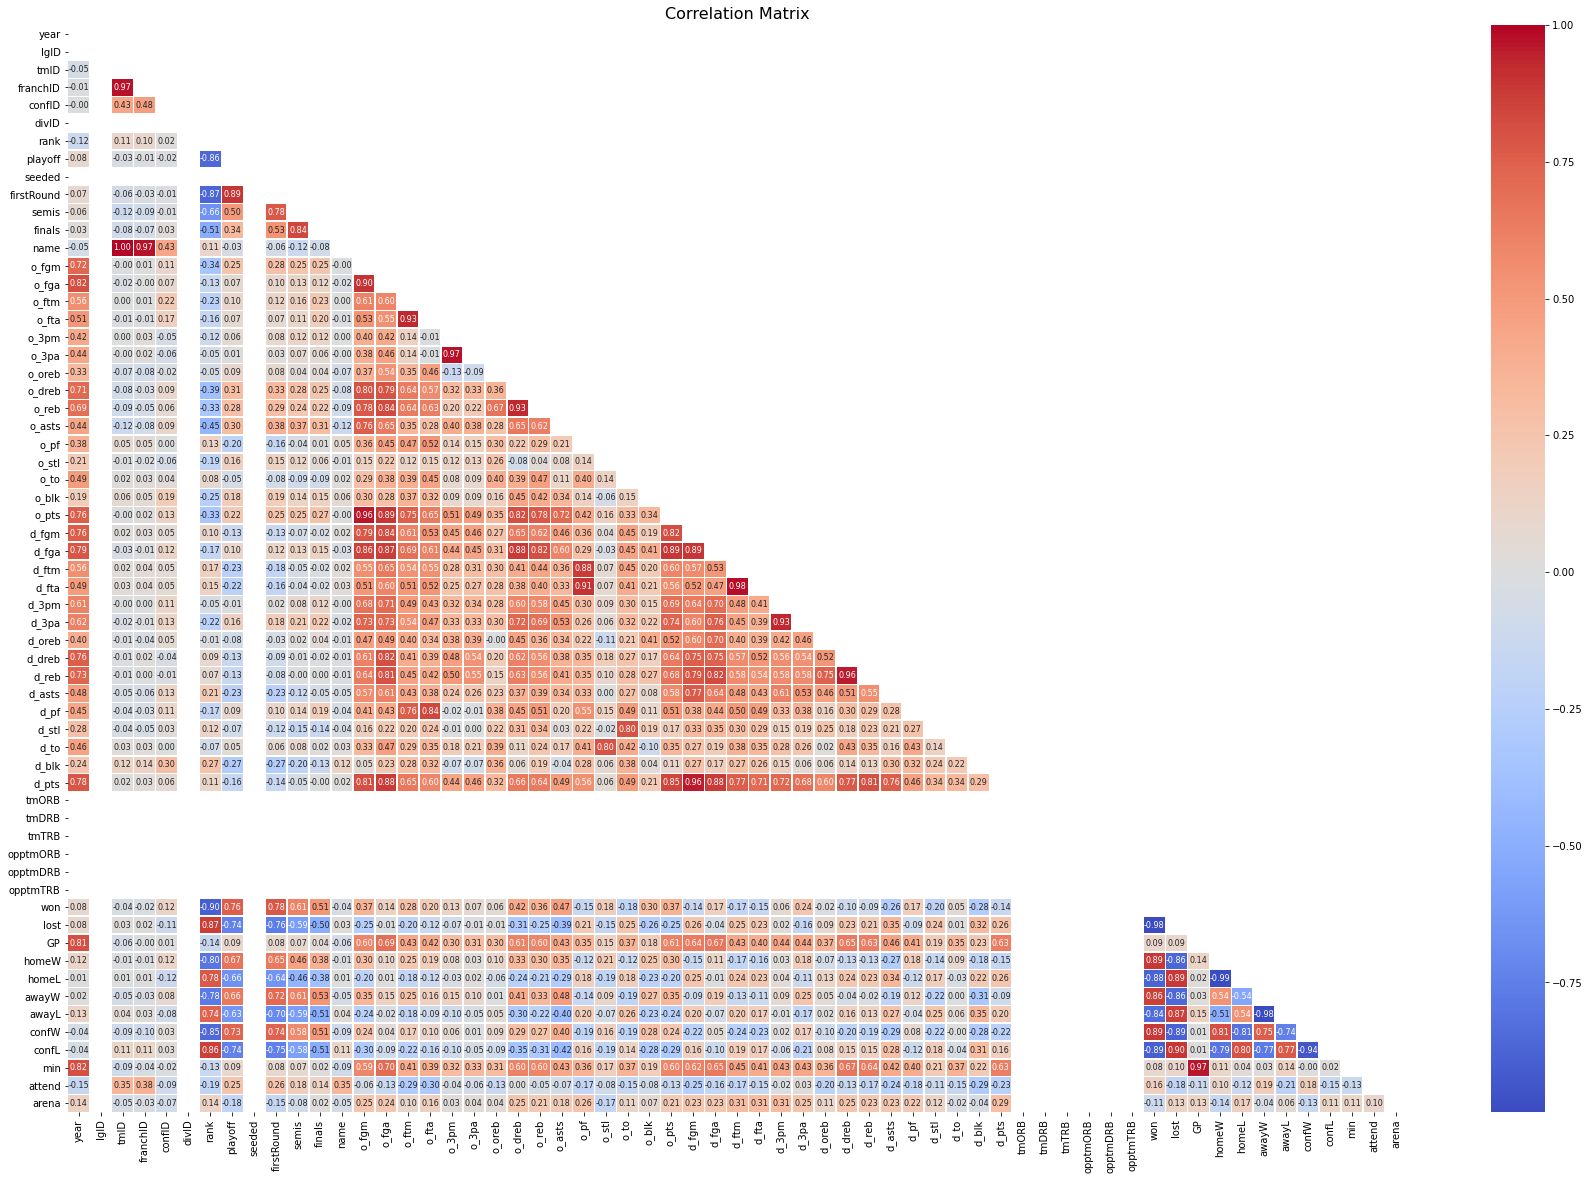

Correlation between target and year: 0.07705063246068848
Correlation between target and lgID: nan
Correlation between target and tmID: -0.02529934329892212
Correlation between target and franchID: -0.0065036191928241486
Correlation between target and confID: -0.016000512024577127
Correlation between target and divID: nan
Correlation between target and rank: -0.8620790896686981
Correlation between target and playoff: 1.0
Correlation between target and seeded: nan
Correlation between target and firstRound: 0.892828570971414
Correlation between target and semis: 0.4970630193302927
Correlation between target and finals: 0.336817912482514
Correlation between target and name: -0.02529934329892215
Correlation between target and o_fgm: 0.2515792808650922
Correlation between target and o_fga: 0.07084000425330679
Correlation between target and o_ftm: 0.1047223173119909
Correlation between target and o_fta: 0.0724933405057681
Correlation between target and o_3pm: 0.060612269288855054
Correlation 

{'year': 0.07705063246068848,
 'lgID': nan,
 'tmID': -0.02529934329892212,
 'franchID': -0.0065036191928241486,
 'confID': -0.016000512024577127,
 'divID': nan,
 'rank': -0.8620790896686981,
 'playoff': 1.0,
 'seeded': nan,
 'firstRound': 0.892828570971414,
 'semis': 0.4970630193302927,
 'finals': 0.336817912482514,
 'name': -0.02529934329892215,
 'o_fgm': 0.2515792808650922,
 'o_fga': 0.07084000425330679,
 'o_ftm': 0.1047223173119909,
 'o_fta': 0.0724933405057681,
 'o_3pm': 0.060612269288855054,
 'o_3pa': 0.007957559282677005,
 'o_oreb': 0.0923630258772151,
 'o_dreb': 0.30755716728105326,
 'o_reb': 0.2794116621840806,
 'o_asts': 0.3032475605334074,
 'o_pf': -0.2029192427184587,
 'o_stl': 0.1648824091126278,
 'o_to': -0.051552794336507696,
 'o_blk': 0.17871539023127894,
 'o_pts': 0.2213991839184398,
 'd_fgm': -0.1300557721536696,
 'd_fga': 0.10293846565632093,
 'd_ftm': -0.23395831262583386,
 'd_fta': -0.2196777440462202,
 'd_3pm': -0.00932954576569799,
 'd_3pa': 0.15591906469556485,
 

In [14]:
correlation_matrix(teams_numeric)

### Players metrics

In [15]:
print(players['playerID'].nunique()) 

print(players.head())

players.isnull().sum()

893
     playerID  pos  firstseason  lastseason  height  weight  \
0  abrahta01w    C            0           0    74.0     190   
1  abrossv01w    F            0           0    74.0     169   
2  adairje01w    C            0           0    76.0     197   
3  adamsda01w  F-C            0           0    73.0     239   
4  adamsjo01w    C            0           0    75.0     180   

             college            collegeOther   birthDate   deathDate  
0  George Washington                     NaN  1975-09-27  0000-00-00  
1        Connecticut                     NaN  1980-07-09  0000-00-00  
2  George Washington                     NaN  1986-12-19  0000-00-00  
3          Texas A&M  Jefferson College (JC)  1989-02-19  0000-00-00  
4         New Mexico                     NaN  1981-05-24  0000-00-00  


playerID          0
pos              78
firstseason       0
lastseason        0
height            0
weight            0
college         167
collegeOther    882
birthDate         0
deathDate         0
dtype: int64

#### Erased columns and why

In [16]:
# Dropped columns: 'collegeOther', 'deathDate', 'firstseason', 'lastseason'

# Count the rows where 'firstseason' is not equal to 0
non_zero_firstseason_count = len(players[players['firstseason'] != 0])

# Count the rows where 'firstseason' is not equal to 0
non_zero_lastseason_count = len(players[players['lastseason'] != 0])

# Count the rows where 'deathDate' is not equal to "0000-00-00"
players['deathDate'] = players['deathDate'].str.strip()
non_empty_deathDate_count = len(players[players['deathDate'] != "0000-00-00"])

# Count the rows where 'collegeOther' is not equal to ""
non_nan_collegeOther_count = players['collegeOther'].notna().sum()

print("Number of rows with 'firstseason' different from 0:", non_zero_firstseason_count)
print("Number of rows with 'lastseason' different from 0:", non_zero_lastseason_count)
print("Number of rows with 'collegeOther' different from "":", non_nan_collegeOther_count)
print("Number of rows with 'deathDate' different from '0000-00-00':", non_empty_deathDate_count)

Number of rows with 'firstseason' different from 0: 0
Number of rows with 'lastseason' different from 0: 0
Number of rows with 'collegeOther' different from : 11
Number of rows with 'deathDate' different from '0000-00-00': 4


#### Players heights comparison

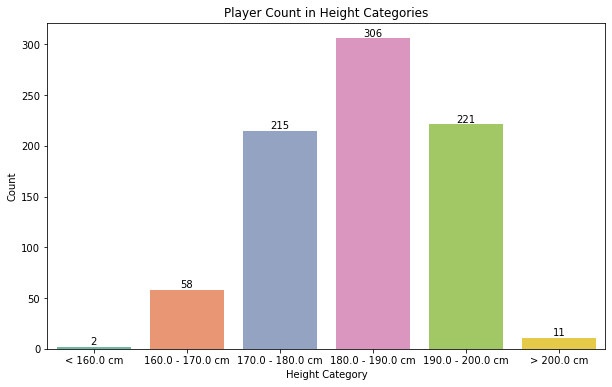

In [17]:
# Convert height from inches to centimeters
players['height_cm'] = players['height'] * 2.54  # 1 inch = 2.54 cm

# Define height categories in centimeters
height_categories = ['< 160.0 cm', '160.0 - 170.0 cm', '170.0 - 180.0 cm', '180.0 - 190.0 cm', '190.0 - 200.0 cm', '> 200.0 cm']

# Define the height ranges for each category
height_ranges = [(0, 160.0), (160.0, 170.0), (170.0, 180.0), (180.0, 190.0), (190.0, 200.0), (200.0, float('inf'))]

# Create a new column in the dataset to store the height category for each player
players['height_category'] = pd.cut(players['height_cm'], bins=[r[0] for r in height_ranges] + [float('inf')], labels=height_categories)

# Count the number of players in each height category
height_category_counts = players['height_category'].value_counts().reindex(height_categories, fill_value=0)

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=height_category_counts.index, y=height_category_counts.values, palette='Set2')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Set plot title and labels
plt.title('Player Count in Height Categories')
plt.xlabel('Height Category')
plt.ylabel('Count')

# Show the plot
plt.show()

#### Number of players in each position

Number of rows with empty 'pos': 78


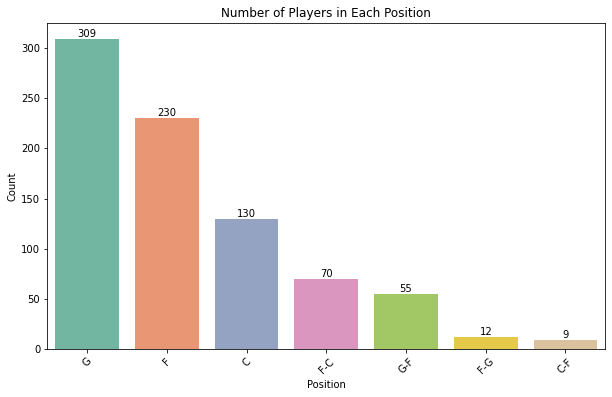

In [18]:
# Create a countplot for player positions
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.countplot(data=players, x='pos', order=players['pos'].value_counts().index, palette='Set2')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Set plot title and labels
plt.title('Number of Players in Each Position')
plt.xlabel('Position')
plt.ylabel('Count')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

empty_pos_count = players['pos'].isnull().sum()
print("Number of rows with empty 'pos':", empty_pos_count)

# Show the plot
plt.show()

#### Top 10 Colleges

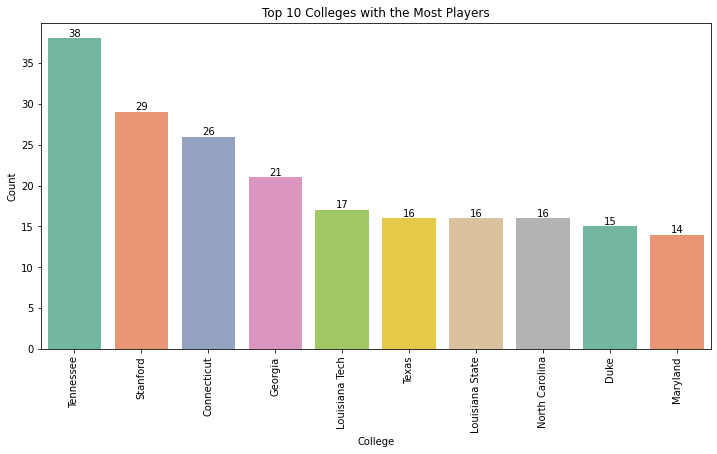

In [19]:
# Get the top 10 colleges with the most players
top_10_colleges = players['college'].value_counts().iloc[:10]

# Create a countplot for the top 10 colleges
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
ax = sns.countplot(data=players, x='college', order=top_10_colleges.index, palette='Set2')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Set plot title and labels
plt.title('Top 10 Colleges with the Most Players')
plt.xlabel('College')
plt.ylabel('Count')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

# Show the plot
plt.show()

#### Correlation Matrix between numeric columns

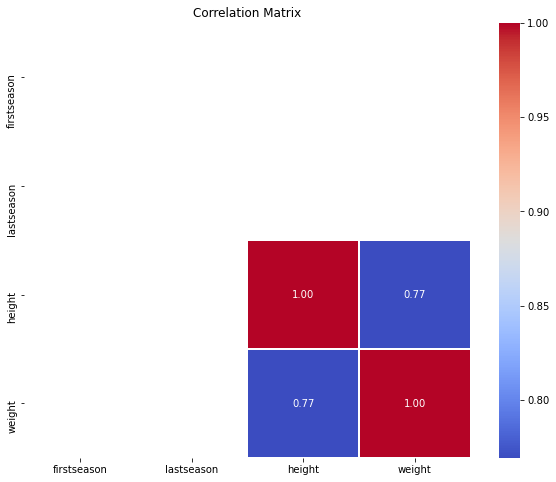

In [20]:
# Select the columns for correlation analysis
numeric_columns = ["firstseason", "lastseason", "height", "weight"]

# Create a subset of the dataset with only the numeric columns
subset = players[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = subset.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Teams Post metrics

In [21]:
print(teams_post.head())

teams_post.isnull().sum()

   year tmID  lgID  W  L
0     1  HOU  WNBA  6  0
1     1  ORL  WNBA  1  2
2     1  CLE  WNBA  3  3
3     1  WAS  WNBA  0  2
4     1  NYL  WNBA  4  3


year    0
tmID    0
lgID    0
W       0
L       0
dtype: int64

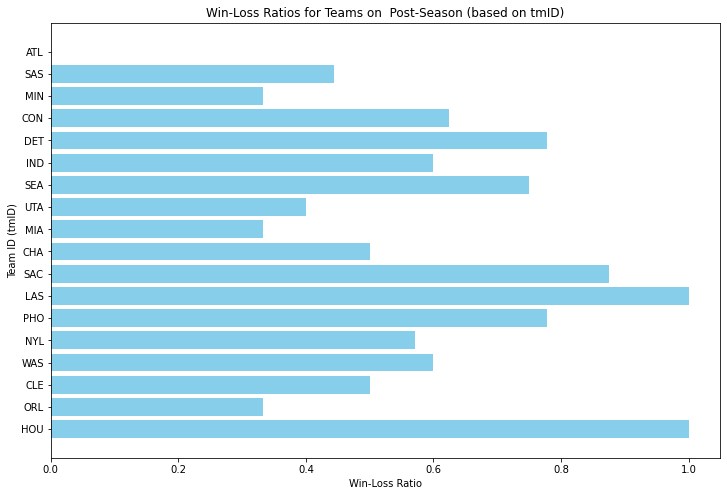

In [22]:
# Calculate win-loss ratios
teams_post['Win-Loss Ratio'] = teams_post['W'] / (teams_post['W'] + teams_post['L'])

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(teams_post['tmID'], teams_post['Win-Loss Ratio'], color='skyblue')

# Add labels and title
plt.xlabel('Win-Loss Ratio')
plt.ylabel('Team ID (tmID)')
plt.title('Win-Loss Ratios for Teams on  Post-Season (based on tmID)')

# Show the chart
plt.show()

### Series Post metrics

<Figure size 864x576 with 0 Axes>

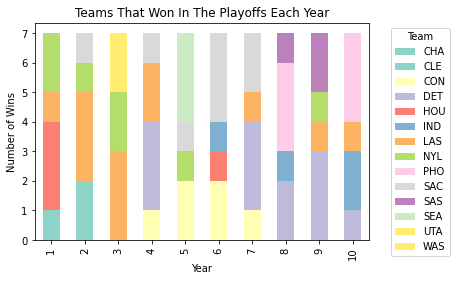

In [23]:
# Group the data by year and count the number of wins for each team in each year
team_wins_by_year = series_post.groupby(['year', 'tmIDWinner'])['W'].count().unstack(fill_value=0)

# Create a stacked bar chart
plt.figure(figsize=(12, 8))
team_wins_by_year.plot(kind='bar', stacked=True, colormap='Set3')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.title('Teams That Won In The Playoffs Each Year')

# Show the chart
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Teams that won and lost each year

In [24]:
# Filter for the "F" (Finals) round
finals_data = series_post[series_post['round'] == 'F']

# Create a DataFrame with the winning and losing teams for each year
finals_results = finals_data[['year', 'tmIDWinner', 'tmIDLoser']]

# Convert the DataFrame to a prettily formatted table
table = tabulate(finals_results, headers='keys', tablefmt='fancy_grid', showindex=False)

# Display the formatted table
print(table)

╒════════╤══════════════╤═════════════╕
│   year │ tmIDWinner   │ tmIDLoser   │
╞════════╪══════════════╪═════════════╡
│      1 │ HOU          │ NYL         │
├────────┼──────────────┼─────────────┤
│      2 │ LAS          │ CHA         │
├────────┼──────────────┼─────────────┤
│      3 │ LAS          │ NYL         │
├────────┼──────────────┼─────────────┤
│      4 │ DET          │ LAS         │
├────────┼──────────────┼─────────────┤
│      5 │ SEA          │ CON         │
├────────┼──────────────┼─────────────┤
│      6 │ SAC          │ CON         │
├────────┼──────────────┼─────────────┤
│      7 │ DET          │ SAC         │
├────────┼──────────────┼─────────────┤
│      8 │ PHO          │ DET         │
├────────┼──────────────┼─────────────┤
│      9 │ DET          │ SAS         │
├────────┼──────────────┼─────────────┤
│     10 │ PHO          │ IND         │
╘════════╧══════════════╧═════════════╛


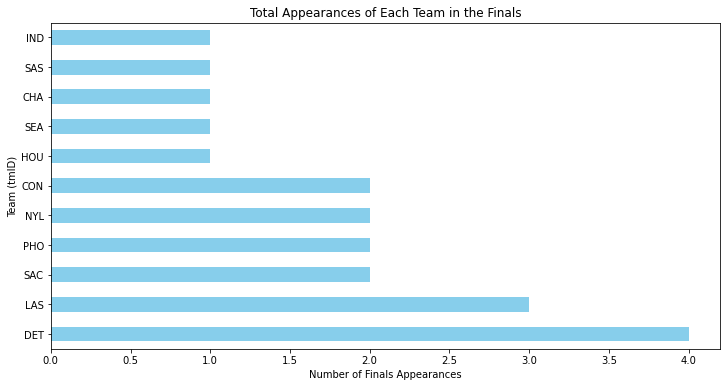

In [25]:
# Filter for the "F" (Finals) round
finals_data = series_post[series_post['round'] == 'F']

# Count how many times each team has appeared in the Finals as either a winner or a loser
team_appearances = pd.concat([finals_data['tmIDWinner'], finals_data['tmIDLoser']]).value_counts()

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
team_appearances.plot(kind='barh', color='skyblue')

# Add labels and title
plt.ylabel('Team (tmID)')
plt.xlabel('Number of Finals Appearances')
plt.title('Total Appearances of Each Team in the Finals')

# Show the chart
plt.show()

### Coaches metrics

In [26]:
print(coaches['coachID'].nunique()) 

print(coaches.head())

coaches.isnull().sum()

57
      coachID  year tmID  lgID  stint  won  lost  post_wins  post_losses
0  adamsmi01w     5  WAS  WNBA      0   17    17          1            2
1  adubari99w     1  NYL  WNBA      0   20    12          4            3
2  adubari99w     2  NYL  WNBA      0   21    11          3            3
3  adubari99w     3  NYL  WNBA      0   18    14          4            4
4  adubari99w     4  NYL  WNBA      0   16    18          0            0


coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64

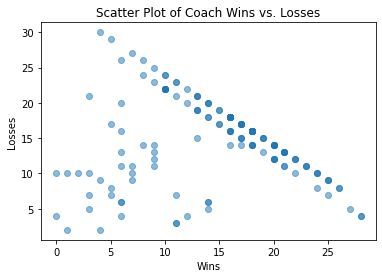

In [27]:
# Extract the wins and losses data from the "won" and "lost" columns
coach_wins = coaches['won']
coach_losses = coaches['lost']

# Create a scatter plot
import matplotlib.pyplot as plt

plt.scatter(coach_wins, coach_losses, alpha=0.5)
plt.xlabel('Wins')
plt.ylabel('Losses')
plt.title('Scatter Plot of Coach Wins vs. Losses')
plt.show()

## Feature Selection

Identify and select relevant features for your prediction model. Use techniques such as correlation analysis, recursive feature elimination, or feature importance from tree-based models.

### Teams dataset

In [28]:
original_teams = teams.copy()

In [29]:
# to delete: lgID, divID, seeded, tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB, rank, firstRound, semis, finals
print(teams.isna().sum())
   
feature_selection_result = teams.drop(columns=['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'])
feature_selection_result = feature_selection_result.drop(columns=['rank', 'firstRound', 'semis', 'finals'])
feature_selection_result = feature_selection_result.drop(columns=['min', 'o_oreb', 'o_dreb', 'd_oreb', 'd_dreb', 'name', 'franchID'])

feature_selection_result.head()

year        0
lgID        0
tmID        0
franchID    0
confID      0
           ..
confW       0
confL       0
min         0
attend      0
arena       0
Length: 61, dtype: int64


,year,tmID,confID,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,...,lost,GP,homeW,homeL,awayW,awayL,confW,confL,attend,arena
0,9,ATL,EA,N,895,2258,542,725,202,598,...,30,34,1,16,3,14,2,18,141379,Philips Arena
1,10,ATL,EA,Y,1089,2428,569,755,114,374,...,16,34,12,5,6,11,10,12,120737,Philips Arena
2,1,CHA,EA,N,812,1903,431,577,131,386,...,24,32,5,11,3,13,5,16,90963,Charlotte Coliseum
3,2,CHA,EA,Y,746,1780,410,528,153,428,...,14,32,11,5,7,9,15,6,105525,Charlotte Coliseum
4,3,CHA,EA,Y,770,1790,490,663,211,527,...,14,32,11,5,7,9,12,9,106670,Charlotte Coliseum


In [30]:
feature_selection_result.to_csv('filtered/feature_selection_dataset.csv', index=False)

## Feature Engineering

Create new features that might enhance the predictive power of your model. This could involve transforming existing features, creating interaction terms, or incorporating external data.

The feauture enginnering is done inside the `players.ipynb` file and the creation of the new dataset is done inside `create_final_team.csv` file.

In [31]:
# TODO: verificar se pode ficar assim ou se adicionamos o código cá
feature_engineering_result = pd.read_csv('filtered/feature_engineering_dataset.csv', delimiter=",")

### Shifting target variable

In [32]:
def shift_target_variable(dataset):
    dataset.sort_values(by=['tmID', 'year'], inplace=True)

    dataset['playoffs'] = dataset.groupby('tmID')['playoff'].shift(-1)

    dataset.drop(columns=['playoff'], inplace=True)

    dataset.dropna(subset=['playoffs'], inplace=True)

    dataset.rename(columns={'playoffs': 'playoff'}, inplace=True)

    dataset.reset_index(drop=True, inplace=True)

    return dataset

#### Original dataset

In [33]:
original_teams = shift_target_variable(original_teams)

#### Feature Selection dataset

In [34]:
feature_selection_result = shift_target_variable(feature_selection_result)

#### Feature engineering dataset

In [35]:
feature_engineering_result = shift_target_variable(feature_engineering_result)

In [36]:
feature_engineering_result2 = pd.read_csv('filtered/team2.csv', delimiter=",")
feature_engineering_result2.drop(columns=['playoff'], inplace=True)

feature_engineering_result2 = pd.merge(feature_engineering_result, feature_engineering_result2, on=['tmID', 'year'])

feature_engineering_result2.to_csv('text.csv', index=False)

## Classification

### Encoding

#### Original

In [37]:
#tmID, confID, playoff, arena
# name, franchID, lgID, divID

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the columns 'teamID', 'franchID', 'confID', 'name', 'arena'
original_teams['tmID'] = label_encoder.fit_transform(original_teams['tmID'])
original_teams['confID'] = label_encoder.fit_transform(original_teams['confID'])
original_teams['arena'] = label_encoder.fit_transform(original_teams['arena'])
original_teams['name'] = label_encoder.fit_transform(original_teams['name'])
original_teams['franchID'] = label_encoder.fit_transform(original_teams['franchID'])
original_teams['lgID'] = label_encoder.fit_transform(original_teams['lgID'])
original_teams['divID'] = label_encoder.fit_transform(original_teams['divID'])
original_teams['firstRound'] = label_encoder.fit_transform(original_teams['firstRound'])
original_teams['semis'] = label_encoder.fit_transform(original_teams['semis'])
original_teams['finals'] = label_encoder.fit_transform(original_teams['finals'])

#### After Feature Selection

In [38]:
feature_selection_result['tmID'] = label_encoder.fit_transform(feature_selection_result['tmID'])
feature_selection_result['confID'] = label_encoder.fit_transform(feature_selection_result['confID'])
feature_selection_result['arena'] = label_encoder.fit_transform(feature_selection_result['arena'])

#### After feature engineering

In [39]:
# Apply label encoding to the columns 'teamID'
feature_engineering_result['tmID'] = label_encoder.fit_transform(feature_engineering_result['tmID'])

In [40]:
feature_engineering_result2['tmID'] = label_encoder.fit_transform(feature_engineering_result2['tmID'])
feature_engineering_result2['confID'] = label_encoder.fit_transform(feature_engineering_result2['confID'])
feature_engineering_result2['arena'] = label_encoder.fit_transform(feature_engineering_result2['arena'])
feature_engineering_result2['firstRound'] = label_encoder.fit_transform(feature_engineering_result2['firstRound'])
feature_engineering_result2['semis'] = label_encoder.fit_transform(feature_engineering_result2['semis'])
feature_engineering_result2['finals'] = label_encoder.fit_transform(feature_engineering_result2['finals'])

### Models

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report

#### Decision Tree

In [43]:
def decision_tree_model(dataset, year): 
    X_train = dataset[dataset['year'] < year].drop(columns=['playoff'])  
    y_train = dataset[dataset['year'] < year]['playoff']

    X_test = dataset[dataset['year'] == year].drop(columns=['playoff'])  
    y_test = dataset[dataset['year'] == year]['playoff']

    model = DecisionTreeClassifier(random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    print(classification_report(y_test, y_pred))

##### Original dataset

In [44]:
decision_tree_model(original_teams, 9)

Accuracy: 0.46
              precision    recall  f1-score   support

           N       0.25      0.20      0.22         5
           Y       0.56      0.62      0.59         8

    accuracy                           0.46        13
   macro avg       0.40      0.41      0.41        13
weighted avg       0.44      0.46      0.45        13



##### Feature Selection dataset

In [45]:
decision_tree_model(feature_selection_result, 9)

Accuracy: 0.69
              precision    recall  f1-score   support

           N       1.00      0.20      0.33         5
           Y       0.67      1.00      0.80         8

    accuracy                           0.69        13
   macro avg       0.83      0.60      0.57        13
weighted avg       0.79      0.69      0.62        13



##### Feature engineering dataset

In [46]:
decision_tree_model(feature_engineering_result, 9)

Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.80      0.62         5
           Y       0.80      0.50      0.62         8

    accuracy                           0.62        13
   macro avg       0.65      0.65      0.62        13
weighted avg       0.68      0.62      0.62        13



In [47]:
decision_tree_model(feature_engineering_result2, 9)

Accuracy: 0.46
              precision    recall  f1-score   support

           N       0.25      0.20      0.22         5
           Y       0.56      0.62      0.59         8

    accuracy                           0.46        13
   macro avg       0.40      0.41      0.41        13
weighted avg       0.44      0.46      0.45        13



#### Random Forest

In [48]:
def random_forest_model(dataset, year): 
    X_train = dataset[dataset['year'] < year].drop(columns=['playoff'])
    y_train = dataset[dataset['year'] < year]['playoff']

    X_test = dataset[dataset['year'] == year].drop(columns=['playoff'])
    y_test = dataset[dataset['year'] == year]['playoff']

    rf_model = RandomForestClassifier(random_state=42)

    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

    print(classification_report(y_test, y_pred_rf))

##### Original dataset

In [49]:
random_forest_model(original_teams, 9)

Random Forest Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.40      0.44         5
           Y       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



##### Feature Selection dataset

In [50]:
random_forest_model(feature_selection_result, 9)

Random Forest Accuracy: 0.54
              precision    recall  f1-score   support

           N       0.40      0.40      0.40         5
           Y       0.62      0.62      0.62         8

    accuracy                           0.54        13
   macro avg       0.51      0.51      0.51        13
weighted avg       0.54      0.54      0.54        13



##### Feature engineering dataset

In [51]:
random_forest_model(feature_engineering_result, 9)

Random Forest Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.40      0.44         5
           Y       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



In [52]:
random_forest_model(feature_engineering_result2, 9)

Random Forest Accuracy: 0.69
              precision    recall  f1-score   support

           N       0.67      0.40      0.50         5
           Y       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



#### Logistic Regression

In [53]:
def logistic_regression_model(dataset, year): 
    X_train = dataset[dataset['year'] < year].drop(columns=['playoff'])
    y_train = dataset[dataset['year'] < year]['playoff']

    X_test = dataset[dataset['year'] == year].drop(columns=['playoff'])
    y_test = dataset[dataset['year'] == year]['playoff']

    logreg_model = LogisticRegression(random_state=42)

    logreg_model.fit(X_train, y_train)

    y_pred_logreg = logreg_model.predict(X_test)

    accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
    print(f"Logistic Regression Accuracy: {accuracy_logreg:.2f}")

    print(classification_report(y_test, y_pred_logreg))

##### Original dataset

In [54]:
logistic_regression_model(original_teams, 9)

Logistic Regression Accuracy: 0.54
              precision    recall  f1-score   support

           N       0.43      0.60      0.50         5
           Y       0.67      0.50      0.57         8

    accuracy                           0.54        13
   macro avg       0.55      0.55      0.54        13
weighted avg       0.58      0.54      0.54        13



c:\Users\anete\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Feature Selection dataset

In [55]:
logistic_regression_model(feature_selection_result, 9)

Logistic Regression Accuracy: 0.54
              precision    recall  f1-score   support

           N       0.40      0.40      0.40         5
           Y       0.62      0.62      0.62         8

    accuracy                           0.54        13
   macro avg       0.51      0.51      0.51        13
weighted avg       0.54      0.54      0.54        13



c:\Users\anete\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Feature Engineering dataset

In [56]:
logistic_regression_model(feature_engineering_result, 9)

Logistic Regression Accuracy: 0.54
              precision    recall  f1-score   support

           N       0.33      0.20      0.25         5
           Y       0.60      0.75      0.67         8

    accuracy                           0.54        13
   macro avg       0.47      0.47      0.46        13
weighted avg       0.50      0.54      0.51        13



In [57]:
logistic_regression_model(feature_engineering_result2, 9)

Logistic Regression Accuracy: 0.54
              precision    recall  f1-score   support

           N       0.33      0.20      0.25         5
           Y       0.60      0.75      0.67         8

    accuracy                           0.54        13
   macro avg       0.47      0.47      0.46        13
weighted avg       0.50      0.54      0.51        13



c:\Users\anete\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Support Vector Machines (SVM)

In [58]:
def svm_model(dataset, year): 
    X_train = dataset[dataset['year'] < year].drop(columns=['playoff'])
    y_train = dataset[dataset['year'] < year]['playoff']

    X_test = dataset[dataset['year'] == year].drop(columns=['playoff'])
    y_test = dataset[dataset['year'] == year]['playoff']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_model = SVC(random_state=42)

    svm_model.fit(X_train_scaled, y_train)

    y_pred_svm = svm_model.predict(X_test_scaled)

    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"Support Vector Machine Accuracy: {accuracy_svm:.2f}")

    print(classification_report(y_test, y_pred_svm))

##### Original dataset

In [59]:
svm_model(original_teams, 9)

Support Vector Machine Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.40      0.44         5
           Y       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



##### Feature Selection dataset

In [60]:
svm_model(feature_selection_result, 9)

Support Vector Machine Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.40      0.44         5
           Y       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



##### Feature engineering dataset

In [61]:
svm_model(feature_engineering_result, 9)

Support Vector Machine Accuracy: 0.54
              precision    recall  f1-score   support

           N       0.40      0.40      0.40         5
           Y       0.62      0.62      0.62         8

    accuracy                           0.54        13
   macro avg       0.51      0.51      0.51        13
weighted avg       0.54      0.54      0.54        13



In [62]:
svm_model(feature_engineering_result2, 9)

Support Vector Machine Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.40      0.44         5
           Y       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



#### KNN dataset

In [100]:
def knn_model(dataset, year, n_neighbors=3):
    # Separate the training and testing sets
    X_train = dataset[dataset['year'] < year].drop(columns=['playoff'])
    y_train = dataset[dataset['year'] < year]['playoff']

    X_test = dataset[dataset['year'] == year].drop(columns=['playoff'])
    y_test = dataset[dataset['year'] == year]['playoff']

    # Create and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_knn = knn_model.predict(X_test)

    # Evaluate and print the model performance
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    print(f"KNN Accuracy: {accuracy_knn:.2f}")

    print(classification_report(y_test, y_pred_knn))

##### Original dataset

In [101]:
knn_model(original_teams, 9)

KNN Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.60      0.55         5
           Y       0.71      0.62      0.67         8

    accuracy                           0.62        13
   macro avg       0.61      0.61      0.61        13
weighted avg       0.63      0.62      0.62        13



##### Feature Selection dataset

In [102]:
knn_model(feature_selection_result, 9)

KNN Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.60      0.55         5
           Y       0.71      0.62      0.67         8

    accuracy                           0.62        13
   macro avg       0.61      0.61      0.61        13
weighted avg       0.63      0.62      0.62        13



##### Feature engineering dataset

In [103]:
knn_model(feature_engineering_result, 9)

KNN Accuracy: 0.62
              precision    recall  f1-score   support

           N       0.50      0.60      0.55         5
           Y       0.71      0.62      0.67         8

    accuracy                           0.62        13
   macro avg       0.61      0.61      0.61        13
weighted avg       0.63      0.62      0.62        13



In [105]:
knn_model(feature_engineering_result2, 9)

AttributeError: 'NoneType' object has no attribute 'split'

## Model Evaluation